Step 1: Load the Data which is prepared from the nuscenes dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the Excel file
df = pd.read_excel('BoxAB_PCD_Association.xlsx')


In [3]:
print(df.columns.tolist())

['Unnamed: 0', 'a_scene_token', 'a_scene_name', 'a_sample_token', 'a_next_sample_token', 'a_instance_token', 'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 'a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z', 'a_box_size_l', 'a_box_size_w', 'a_box_size_h', 'a_box_rotation_w', 'a_box_rotation_x', 'a_box_rotation_y', 'a_box_rotation_z', 'a_box_category_name', 'a_box_rad_translation_x', 'a_box_rad_translation_y', 'a_box_rad_translation_z', 'a_box_rad_rotation_w', 'a_box_rad_rotation_x', 'a_box_rad_rotation_y', 'a_box_rad_rotation_z', 'a_box_rad_size_l', 'a_box_rad_size_w', 'a_box_rad_size_h', 'a_radar_radar_token', 'a_radar_radar_x', 'a_radar_radar_y', 'a_radar_radar_z', 'a_radar_radar_trans_x', 'a_radar_radar_trans_y', 'a_radar_radar_trans_z', 'a_radar_dyn_prop', 'a_radar_cluster_id', 'a_radar_rcs', 'a_radar_vx', 'a_radar_vy', 'a_radar_vx_comp', 'a_radar_vy_comp', 'a_radar_is_quality_valid', 'a_radar_ambig_state', 'a_radar_x_rms', 'a_radar_y_rms', 'a_radar_inval

In [4]:
df_work = df.copy()
df_work = df_work[['a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 'a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z', 
                        'a_box_size_l', 'a_box_size_w', 'a_box_size_h', 
                        'a_box_rotation_w', 'a_box_rotation_x', 'a_box_rotation_y', 'a_box_rotation_z', 
                        'a_box_category_name','a_radar_dyn_prop', 'a_radar_radar_distance', 
                        'a_can_brake', 'a_can_brake_switch', 'a_can_rear_left_rpm', 'a_can_rear_right_rpm', 'a_can_vehicle_speed', 'a_can_yaw_rate',
                        'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 'b_box_translation_x', 'b_box_translation_y', 'b_box_translation_z', 
                        'b_box_size_l', 'b_box_size_w', 'b_box_size_h', 
                        'b_box_rotation_w', 'b_box_rotation_x', 'b_box_rotation_y', 'b_box_rotation_z', 
                        'b_box_category_name', 'b_radar_dyn_prop', 'b_radar_radar_distance', 
                        'b_can_brake', 'b_can_brake_switch', 'b_can_rear_left_rpm', 'b_can_rear_right_rpm', 'b_can_vehicle_speed', 'b_can_yaw_rate']]

In [5]:
dynprop_map = {
    0: 'Moving',
    1: 'Stationary',
    2: 'Oncoming',
    3: 'Stationary Candidate',
    4: 'Unknown',
    5: 'Crossing Stationary',
    6: 'Crossing Moving',
    7: 'Stopped'
}

df_work['a_dyn_label'] = df_work['a_radar_dyn_prop'].map(dynprop_map)

In [6]:
df_work.duplicated().sum()

np.int64(218)

In [7]:
df_work = df_work.drop_duplicates()
df_work.shape

(9264, 45)

In [8]:
df_work.groupby(['a_dyn_label', 'a_radar_dyn_prop'])[['a_radar_dyn_prop']].count()

,,a_radar_dyn_prop
a_dyn_label,a_radar_dyn_prop,
Crossing Moving,6,772
Crossing Stationary,5,225
Moving,0,1062
Oncoming,2,422
Stationary,1,6031
Stationary Candidate,3,752


<Axes: title={'center': 'DynProp Distribution'}, xlabel='a_dyn_label'>

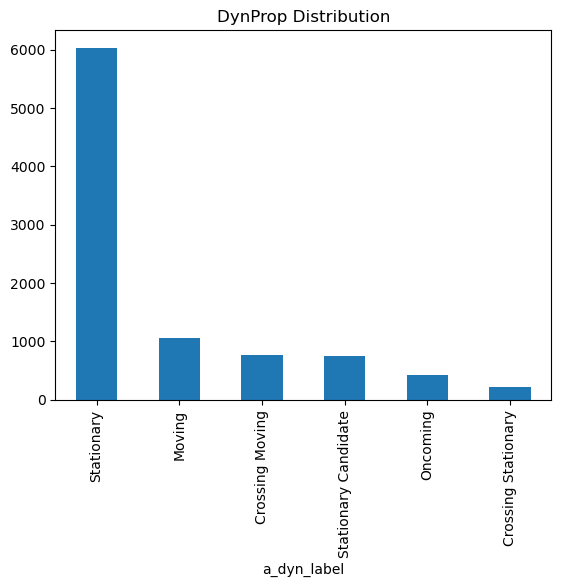

In [9]:
df_work['a_dyn_label'].value_counts().plot(kind='bar', title='DynProp Distribution')

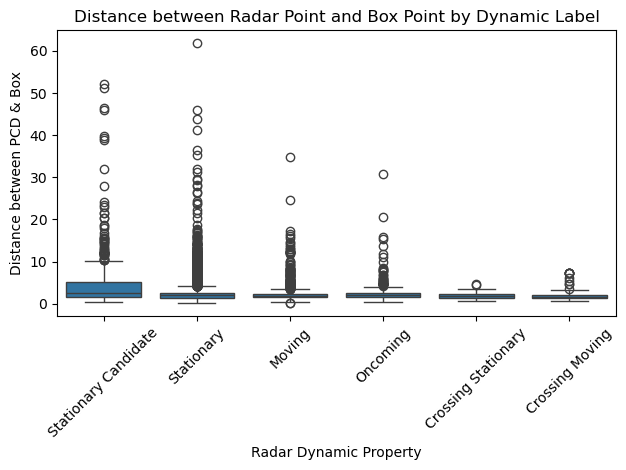

In [10]:
sns.boxplot(x='a_dyn_label', y='a_radar_radar_distance', data=df_work)
plt.xticks(rotation=45)  # Slants the labels
plt.xlabel('Radar Dynamic Property')
plt.ylabel('Distance between PCD & Box')

plt.title('Distance between Radar Point and Box Point by Dynamic Label')
plt.tight_layout()
plt.show()


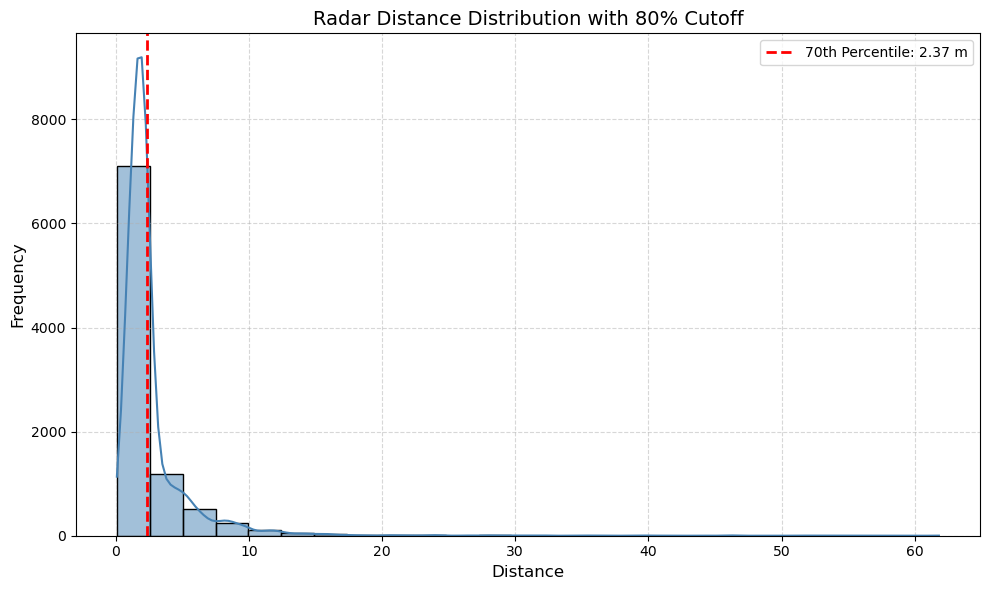

In [11]:

# Calculate the 85th percentile
cutoff_70 = np.percentile(df_work['a_radar_radar_distance'].dropna(), 70)

# Plot histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_work['a_radar_radar_distance'], bins=25, kde=True, color='steelblue')

# Add vertical line for 85th percentile
plt.axvline(cutoff_70, color='red', linestyle='--', linewidth=2, label=f'70th Percentile: {cutoff_70:.2f} m')

# Annotate and style
plt.title('Radar Distance Distribution with 80% Cutoff', fontsize=14)
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.show()


In [12]:
# Drop NaNs to avoid issues
radar_distances = df_work['a_radar_radar_distance'].dropna()

# Calculate the 85th percentile cutoff
cutoff_70 = np.percentile(radar_distances, 70)

# Count points below and above the cutoff
count_below = (radar_distances <= cutoff_70).sum()
count_above = (radar_distances > cutoff_70).sum()

print(f"Total points  : {count_below+count_above}")
print(f"Data points ≤ 70th percentile ({cutoff_70:.2f} ): {count_below}")
print(f"Data points > 70th percentile: {count_above}")


Total points  : 9264
Data points ≤ 70th percentile (2.37 ): 6486
Data points > 70th percentile: 2778


In [13]:
# Drop NaNs to avoid issues
radar_distances = df_work['a_radar_radar_distance'].dropna()

# Define fixed cutoff
cutoff_distance = 2

# Count points below and above the cutoff
count_below = (radar_distances <= cutoff_distance).sum()
count_above = (radar_distances > cutoff_distance).sum()

print(f"Total points  : {count_below + count_above}")
print(f"Data points ≤ {cutoff_distance} meters: {count_below}")
print(f"Data points > {cutoff_distance} meters: {count_above}")


Total points  : 9264
Data points ≤ 2 meters: 4805
Data points > 2 meters: 4459


In [14]:
radar_distances = df_work['a_radar_radar_distance'].dropna()
cutoff_distance = 2

# Filter the original DataFrame
df_below_80 = df_work[df_work['a_radar_radar_distance'] <= cutoff_distance]

In [15]:
df_below_80.shape

(4805, 45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Stationary'),
  Text(1, 0, 'Moving'),
  Text(2, 0, 'Crossing Moving'),
  Text(3, 0, 'Stationary Candidate'),
  Text(4, 0, 'Oncoming'),
  Text(5, 0, 'Crossing Stationary')])

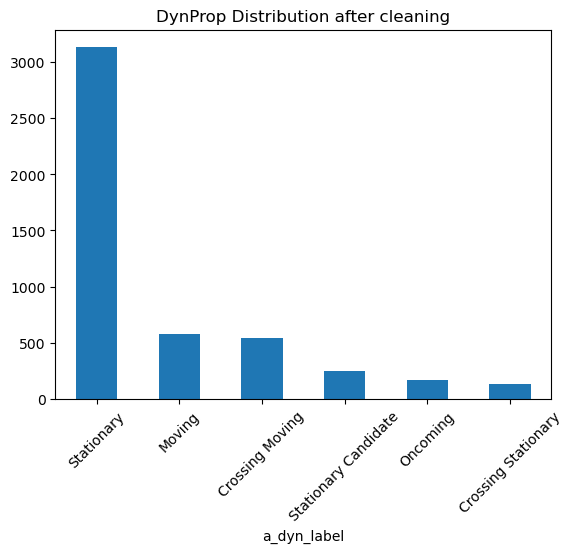

In [16]:
df_below_80['a_dyn_label'].value_counts().plot(kind='bar', title='DynProp Distribution after cleaning')
plt.xticks(rotation=45)  # or try 60 for steeper slant

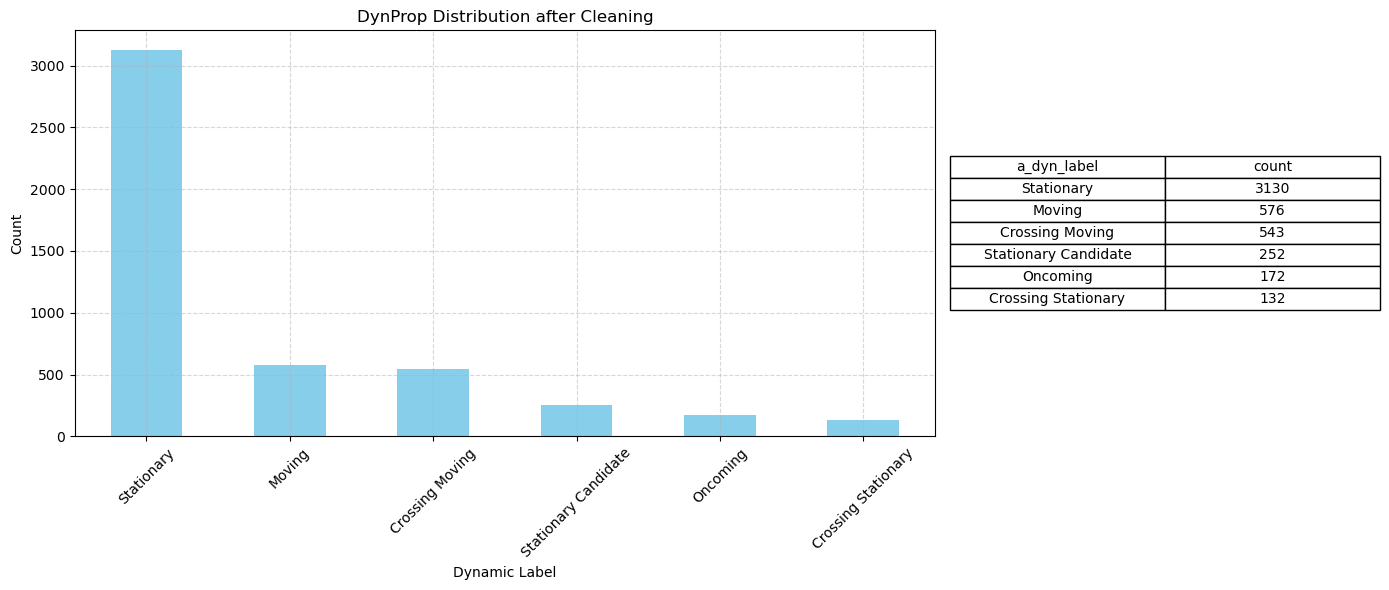

In [17]:
# Prepare data
dyn_counts = df_below_80['a_dyn_label'].value_counts()

# Create figure with two subplots: bar chart (left), table (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# Bar chart
dyn_counts.plot(kind='bar', ax=ax1, color='skyblue', title='DynProp Distribution after Cleaning')
ax1.set_xlabel('Dynamic Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.5)

# Data table
table_data = dyn_counts.reset_index()
table_data.columns = ['a_dyn_label', 'count']
ax2.axis('off')  # Hide axes
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='center')
table.scale(1, 1.5)  # Adjust size
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.tight_layout()
plt.show()


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Stationary Candidate'),
  Text(1, 0, 'Stationary'),
  Text(2, 0, 'Moving'),
  Text(3, 0, 'Oncoming'),
  Text(4, 0, 'Crossing Stationary'),
  Text(5, 0, 'Crossing Moving')])

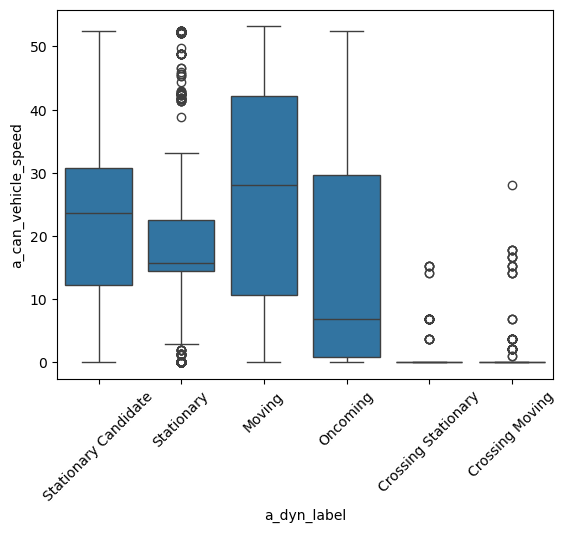

In [18]:
sns.boxplot(x='a_dyn_label', y='a_can_vehicle_speed', data=df_below_80)
plt.xticks(rotation=45)  # Slants the labels